## LIST 3 Unstructured Data Twitter Assignment Michał Kuc and Piotr Paduszyński SET 1


In [2]:
#### Required libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tweepy as tw
from textblob import TextBlob
import datetime
import folium as folium

## Data downloading

First of all we have to scrap tweets with given hashtags from four largest cities in United States.
We have to connect with twitter by our develpor account using personal keys and tokens.

Then we have to use tweepy.Cursor to scrap tweets which we are intersted in.

In [2]:
### Active developer twiiter acount
consumer_key= 'We'
consumer_secret= 'should not'
access_token= 'share'
access_token_secret= 'our keys'


auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [77]:
q ="#GE2020 OR #GE20 OR #GeneralElection OR #GeneralElection2020 OR #Election2020 -filter:retweets"

NY = "40.714353,-74.00597299999998,100km" #Four largest cities geocodes
LA = "34.0207289,-118.6926019,100km"
Houston = "29.7632800,-95.3632700,100km"
WA = "38.8972578,-77.0345083,100km"


US = [NY,LA,Houston,WA]
names = ['NY','LA','Houston','WA']

date = ["2020-11-04","2020-11-05","2020-11-06","2020-11-07","2020-11-08",
       "2020-11-09","2020-11-10","2020-11-11","2020-11-12"] 

#Here is the main loop where we are taking 250 tweets from each city and for exact day.
for k in range(0,len(US)):
    tweet_list = []
    hashtags = [] ### hashtag list
    for i in range(0,len(date)):
        tweets = tw.Cursor(api.search, q, geocode=US[k],lang="en",since=date[i],until=date[i+1],tweet_mode='extended').items(250)

        for tweet in tweets:
            tweet_list.append(tweet)

            h_list = ""
            for h in range(len(tweet.entities['hashtags'])):
                h_list = h_list + tweet.entities['hashtags'][h]['text']+","
            hashtags.append(h_list)

        
            
    outtweets = [[tweet.created_at,  # date of createtion
      tweet.favorite_count, # number of likes
      tweet.retweet_count, # number of retweets 
      tweet.user.location, # location
      TextBlob(tweet.full_text).polarity, # sentiment of post
      tweet.user.name, # user name
      tweet.full_text.encode("utf-8").decode("utf-8").replace("\n","")]  # text 
        for tweet in tweet_list]
    
    #### Save tweets into csv file
    df = pd.DataFrame(outtweets,columns=["created_at","likes","retweets","location","sentiment","user", "text"])
    df.insert(7, "hashtags", hashtags, True) # add hashtag column
    df.to_csv(str(name[k])+".csv") 

## Cleaning data

After scraping tweets we can start to cleaning our data.
First of all we load the data from csv file and merge into one dataframe.

Than we create another columns which contains information about state and who the post is about.


In [3]:
#### Load data 
NYdf = pd.read_csv('NY.csv')
LAdf = pd.read_csv('LA.csv')
HOdf = pd.read_csv('Houston.csv')
WAdf = pd.read_csv('WA.csv')

frames = [NYdf,LAdf,HOdf,WAdf]
all_cities = pd.concat(frames,ignore_index = True)  

In [4]:
#Create columns with State and Candidate
key_words_biden = ['biden','joe','Biden','Joe']
key_words_trump = ['donald','trump','Donald','Trump']

all_cities['Candidate'] = ''
all_cities['State'] = ''

for i in range(len(all_cities)):
    text = all_cities['text'][i]
#     print(i)
    if any(word in text for word in key_words_trump) and not any(word in text for word in key_words_biden):
        all_cities.loc[i, 'Candidate'] = 'Trump'
    elif any(word in text for word in key_words_biden) and not any(word in text for word in key_words_trump):
        all_cities.loc[i, 'Candidate'] = 'Biden'
    elif any(word in text for word in key_words_biden) and any(word in text for word in key_words_trump):
        all_cities.loc[i, 'Candidate'] = 'Both'
    else:
        all_cities.loc[i, 'Candidate'] = 'None'
    
    if i <len(NYdf):
        all_cities.loc[i, 'State'] = 'NY'
    elif i <len(NYdf)+len(LAdf):
        all_cities.loc[i, 'State'] = 'CA'
    elif i <len(NYdf)+len(LAdf)+len(HOdf):
        all_cities.loc[i, 'State'] = 'TX'
    else:
        all_cities.loc[i, 'State'] = 'SC'
     

At the end we create column 'date' which contains only tha date of creation tweet without time.

In [5]:
#### Create column date (date without time)
dates = []

for i in all_cities['created_at']:
    
    data = datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
    
    data2 = datetime.datetime.date(data)

    dates.append(data2)

all_cities.insert(2, "date", dates, True)

del all_cities['Unnamed: 0']

Now we have dataframe which contains information about date of creation tweet, number of likes and retweets, location, sentiment, user, hashatags, candidates, state and text of tweet.

In [11]:
all_cities.head(10)

created_at        date  likes  retweets  \
0  2020-11-04 23:59:57  2020-11-04      3         1   
1  2020-11-04 23:59:11  2020-11-04      0         0   
2  2020-11-04 23:58:30  2020-11-04      4         0   
3  2020-11-04 23:58:24  2020-11-04      1         0   
4  2020-11-04 23:56:59  2020-11-04      4         1   
5  2020-11-04 23:56:01  2020-11-04      0         0   
6  2020-11-04 23:54:42  2020-11-04      4         0   
7  2020-11-04 23:54:05  2020-11-04     95         7   
8  2020-11-04 23:53:40  2020-11-04      0         0   
9  2020-11-04 23:53:36  2020-11-04      2         0   

                       location  sentiment                             user  \
0                      New York    0.00000                      MysterPride   
1         Stamford, Connecticut    0.00000                           GOPFan   
2  New York / संभाजीनगर / पुणे     0.00000  Saurabh Joglekar (सौरभ जोगळेकर)   
3                  New York, NY    0.00000                          ZZsheyn   
4                  Florida, USA    1.00000                         PaDiesel   
5                   Trenton, NJ    0.00000               HellMinded Records   
6                  Brooklyn, NY    0.00000                            ike ♒   
7               New Jersey, USA    0.00000                    ☆ Lou Sifer ☆   
8                 Manhattan, NY   -0.46875                           Teresa   
9                 New York, USA    0.00000                     Emily Febles   

                                                text  \
0  Every Democrat waiting to find out Nevada's Re...   
1  Election prediction after lawsuits #Election20...   
2  Biden-264 Trump-214#Election2020 https://t.co/...   
3  Election results: Presidential race is undecid...   
4  Close Election! Who's gonna win!?! Me...in the...   
5  The irony of all bets now lying with Nevada is...   
6  Come on Nevada bring this to an end!!   #Elect...   
7  The Nevada Election Task Force after counting ...   
8  IT IS ON. THIS IS A WAR LIKE NO OTHER. AN EVIL...   
9  I have also claimed, for electoral vote purpos...   

                                            hashtags Candidate State  
0                           Election2020,Nevada2020,      None    NY  
1   Election2020,Trump2020,MAGA2020,KAG2020,RedWave,     Trump    NY  
2                                      Election2020,      Both    NY  
3                                      Election2020,      None    NY  
4  cod,callofduty,election2020,trump,biden,twitch...      Both    NY  
5                    election2020,gambleresponsibly,      None    NY  
6                                      Election2020,      None    NY  
7                                      Election2020,      None    NY  
8                                      Election2020,     Trump    NY  
9  Election2020,ElectionResults2020,Elections2020...     Biden    NY

## Analysis



We start our analysis with a number of retweets and likes dependent on location and candidates who the post is about.

In [39]:
##### Retweets in states group by candidates

table = all_cities.groupby(['State','Candidate'])['retweets'].sum().reset_index()

table = table.pivot('State','Candidate','retweets')

table.plot.barh(width=0.8,color = ['blue','red','green','yellow'])
plt.title('Number of retweets by states')
plt.xlabel('Value')
plt.show()



In [30]:
##### Likes in states group by candidates

table = all_cities.groupby(['State','Candidate'])['likes'].sum().reset_index()

table = table.pivot('State','Candidate','likes')

table.plot.barh(width=0.8,color = ['blue','red','green','yellow'])
plt.title('Number of likes by states')
plt.xlabel('Value')
plt.show()

Below we present number of daily tweets from our data group by candidates.

In [6]:
##### Tweets about candidates

table = all_cities.groupby(['date','Candidate'])['State'].count().reset_index()

table = table.pivot('date','Candidate','State')

sns.heatmap(table,cmap='RdYlGn',annot=True,fmt='1.0f',lw = 3)
fig=plt.gcf()
fig.set_size_inches(8,6)
plt.title('Number of tweets by days')
plt.xlabel('candidate')
plt.show()

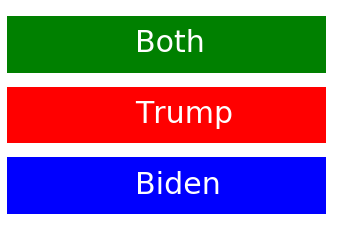

In [23]:
#### Create map with tweets by candidates

CA = [34.0207289,-118.6926019] #Coordinates
NY = [40.714353,-74.00597299999998]
SC = [38.8972578,-77.0345083]
TX = [29.7632800,-95.3632700]


names = ['CA','NY','SC','TX']

table = all_cities.groupby(['State','Candidate'])['date'].count().reset_index()

table = table.pivot('State','Candidate','date')

table_values = [ ]

for column in table.columns.values:
    table_values.append(table[column].tolist())
 

for i in range(len(names)):
    
    name = ['Biden','Trump','Both']
    value = [table_values[0][i],table_values[3][i],table_values[1][i]]
    city = names[i]
    
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    
    ax.bar(name,value,color=['b', 'r', 'g'],width=1)
    ax.axis('off')
    
    plt.savefig(f'{city}.png',transparent=True)
    plt.close()


maps = folium.Map(location=[38,-100],zoom_start=4)


iconCA = folium.features.CustomIcon('./CA.png',icon_size=(60,60))
folium.Marker(location=CA,icon=iconCA).add_to(maps)

iconNY = folium.features.CustomIcon('./NY.png',icon_size=(60,60))
folium.Marker(location=NY,icon=iconNY).add_to(maps)

iconSC = folium.features.CustomIcon('./SC.png',icon_size=(60,60))
folium.Marker(location=SC,icon=iconSC).add_to(maps)

iconTX = folium.features.CustomIcon('./TX.png',icon_size=(60,60))
folium.Marker(location=TX,icon=iconTX).add_to(maps)

plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots()

y_pos = np.arange(3)

ax.barh(y_pos, [1,1,1],color=['b','r','g'])
ax.text(0.4,1.9,'Both',color='w')
ax.text(0.4,0.9,'Trump',color='w')
ax.text(0.4,-0.1,'Biden',color='w')
ax.axis('off') # labels read top-to-bottom


plt.savefig('legend.png')

iconlegend=folium.features.CustomIcon('./legend.png',icon_size=(200,200))
folium.Marker(location=[26,-133],icon=iconlegend).add_to(maps)
maps

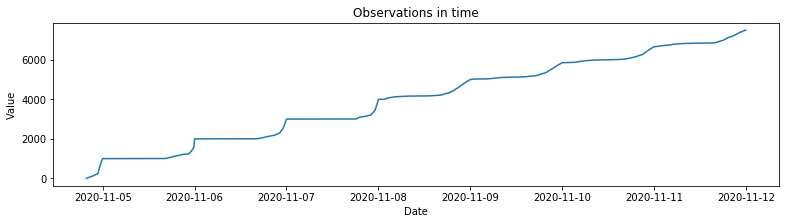

In [49]:
### Tweets in time
all_cities['created_at'] = pd.to_datetime(all_cities['created_at'])

fig = plt.figure(figsize=(13,3))
value = []
iteration = 1
sort=all_cities.sort_values("created_at")
for i in sort["created_at"]:
    value.append(iteration)
    iteration = iteration + 1
    
plt.plot(sort["created_at"],value)
plt.ylabel('Value')
plt.xlabel("Date")
plt.title("Observations in time")
plt.show()

As we can see above, the most tweets came at the end of the day. But it is due to method of data scraping. When we scrap tweets from every single day tw.cursor looking for tweets with decreasing time, so when we take 250 tweets in most cases time of creation tweet is betweene 8 p.m. and 12 p.m. more or less.

## Sentiment of tweets

Firstly we group sentiment of tweets by candidates

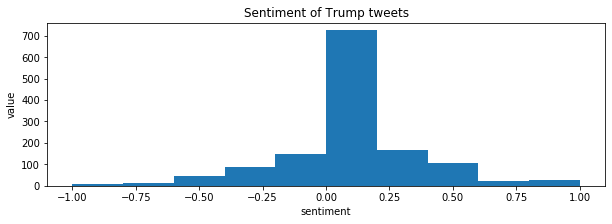

In [120]:
##### Sentiments by candidates
SentBiden = []
SentTrump = []
SentNone = []
SentBoth = []

for i in range(len(all_cities)):
    if all_cities['Candidate'][i] == 'Biden':
        SentBiden.append(all_cities['sentiment'][i])
    if all_cities['Candidate'][i] == 'Trump':
        SentTrump.append(all_cities['sentiment'][i])
    if all_cities['Candidate'][i] == 'None':
        SentNone.append(all_cities['sentiment'][i])
    if all_cities['Candidate'][i] == 'Both':
        SentBoth.append(all_cities['sentiment'][i])

fig = plt.figure(figsize=(10,3))
plt.hist(SentNone)
plt.title('Sentiment of None tweets')
plt.xlabel('sentiment')
plt.ylabel('value')
plt.show()

fig = plt.figure(figsize=(10,3))
plt.hist(SentBiden)
plt.title('Sentiment of Biden tweets')
plt.xlabel('sentiment')
plt.ylabel('value')
plt.show()

fig = plt.figure(figsize=(10,3))
plt.hist(SentTrump)
plt.title('Sentiment of Trump tweets')
plt.xlabel('sentiment')
plt.ylabel('value')
plt.show()

fig = plt.figure(figsize=(10,3))
plt.hist(SentBoth)
plt.title('Sentiment of Both tweets')
plt.xlabel('sentiment')
plt.ylabel('value')
plt.show()

Then we group sentiment of tweets by states

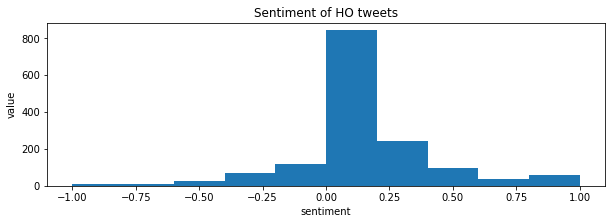

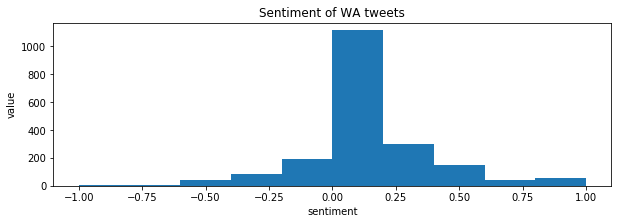

In [119]:
##### Sentiment by states
SentNY = []
SentLA = []
SentHO = []
SentWA = []
for i in range(len(all_cities)):
    if all_cities['State'][i] == 'NY':
        SentNY.append(all_cities['sentiment'][i])
    if all_cities['State'][i] == 'CA':
        SentLA.append(all_cities['sentiment'][i])
    if all_cities['State'][i] == 'TX':
        SentHO.append(all_cities['sentiment'][i])
    if all_cities['State'][i] == 'SC':
        SentWA.append(all_cities['sentiment'][i])
        
fig = plt.figure(figsize=(10,3)) 
plt.hist(SentNY)
plt.title('Sentiment of NY tweets')
plt.xlabel('sentiment')
plt.ylabel('value')
plt.show()

fig = plt.figure(figsize=(10,3))
plt.hist(SentLA)
plt.title('Sentiment of LA tweets')
plt.xlabel('sentiment')
plt.ylabel('value')
plt.show()

fig = plt.figure(figsize=(10,3))
plt.hist(SentHO)
plt.title('Sentiment of HO tweets')
plt.xlabel('sentiment')
plt.ylabel('value')
plt.show()

fig = plt.figure(figsize=(10,3))
plt.hist(SentWA)
plt.title('Sentiment of WA tweets')
plt.xlabel('sentiment')
plt.ylabel('value')
plt.show()

As we can see above tweets about Biden are on average more friendly than tweets about Trump.

Also in general we can see that there is more positive tweets than negative.

But the most popular are tweets with sentiment equal to 0.

Broken down by city distribution looks more or less the same. As in grouping by candidates we have also more positive tweets than negative.

## Hashtag in tweets

First of all we can find the most popular hashtags in all tweets.

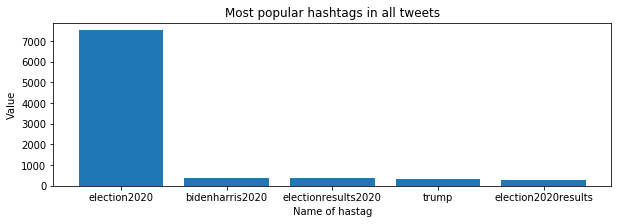

In [116]:
#### Hashtags overall
Hashtag = {}

def get_key(val,Hashtag): 
    for key, value in Hashtag.items(): 
         if val == value: 
            return key 
        
for i in all_cities['hashtags']:
    
    i = i.lower()
    lista = i.split(',')[:-1]
    for element in lista:
        if element in Hashtag:
            Hashtag[element] =  Hashtag[element] + 1
        else:
            Hashtag[element] = 1

f = [values for keys,values in Hashtag.items()]
f.sort()

name = []
values = [] 

for i in range(1,6):
    values.append(f[-i])
    name.append(get_key(f[-i],Hashtag))

fig = plt.figure(figsize=(10,3))
plt.bar(name,values)
plt.title('Most popular hashtags in all tweets')
plt.xlabel('Name of hastag')
plt.ylabel('Value')
plt.show()

Then we can find the most popular hashtags depends on candidates.

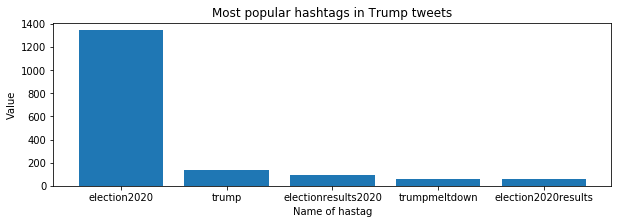

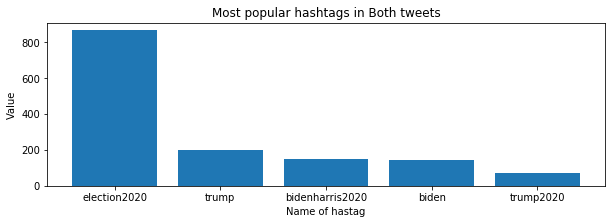

In [117]:
#### Hashtags by candidates
HashtagBiden = {}
HashtagBoth = {}
HashtagNone = {}
HashtagTrump = {}
for i in range(len(all_cities)):

    if all_cities['Candidate'][i] == 'Biden':
        hashtag = all_cities['hashtags'][i]
        hashtag = hashtag.lower()
        lista = hashtag.split(',')[:-1]
        for element in lista:
            if element in HashtagBiden:
                HashtagBiden[element] =  HashtagBiden[element] + 1
            else:
                HashtagBiden[element] = 1
                
    elif all_cities['Candidate'][i] == 'Trump':
        hashtag = all_cities['hashtags'][i]
        hashtag = hashtag.lower()
        lista = hashtag.split(',')[:-1]
        for element in lista:
            if element in HashtagTrump:
                HashtagTrump[element] =  HashtagTrump[element] + 1
            else:
                HashtagTrump[element] = 1
    elif all_cities['Candidate'][i] == 'Both':
        hashtag = all_cities['hashtags'][i]
        hashtag = hashtag.lower()
        lista = hashtag.split(',')[:-1]
        for element in lista:
            if element in HashtagBoth:
                HashtagBoth[element] =  HashtagBoth[element] + 1
            else:
                HashtagBoth[element] = 1
                
    elif all_cities['Candidate'][i] == 'None':
        hashtag = all_cities['hashtags'][i]
        hashtag = hashtag.lower()
        lista = hashtag.split(',')[:-1]
        for element in lista:
            if element in HashtagNone:
                HashtagNone[element] =  HashtagNone[element] + 1
            else:
                HashtagNone[element] = 1
                
f1 = [values for keys,values in HashtagBiden.items()]
f1.sort()
f2 = [values for keys,values in HashtagBoth.items()]
f2.sort()
f3 = [values for keys,values in HashtagTrump.items()]
f3.sort()
f4 = [values for keys,values in HashtagNone.items()]
f4.sort()

name1 = []
values1 = [] 
for i in range(1,7):
    values1.append(f1[-i])
    name1.append(get_key(f1[-i],HashtagBiden))
    
name2 = []
values2 = [] 
for i in range(1,6):
    values2.append(f2[-i])
    name2.append(get_key(f2[-i],HashtagBoth))
    
name3 = []
values3 = [] 
for i in range(1,6):
    values3.append(f3[-i])
    name3.append(get_key(f3[-i],HashtagTrump))
    
name4 = []
values4 = [] 
for i in range(1,6):
    values4.append(f4[-i])
    name4.append(get_key(f4[-i],HashtagNone))


fig = plt.figure(figsize=(10,3))
plt.bar(name4,values4)
plt.title('Most popular hashtags in None tweets')
plt.xlabel('Name of hastag')
plt.ylabel('Value')
plt.show()

fig = plt.figure(figsize=(10,3))
plt.bar(name1,values1)
plt.title('Most popular hashtags in Biden tweets')
plt.xlabel('Name of hastag')
plt.ylabel('Value')
plt.show()



fig = plt.figure(figsize=(10,3))
plt.bar(name3,values3)
plt.title('Most popular hashtags in Trump tweets')
plt.xlabel('Name of hastag')
plt.ylabel('Value')
plt.show()

fig = plt.figure(figsize=(10,3))
plt.bar(name2,values2)
plt.title('Most popular hashtags in Both tweets')
plt.xlabel('Name of hastag')
plt.ylabel('Value')
plt.show()

At the end we can see the most popular hashtags group by cities.

In [118]:
#### Hashtags by cities

#### Hashtags by candidates
HashtagNY = {}
HashtagLA = {}
HashtagHO = {}
HashtagWA = {}

for i in range(len(all_cities)):

    if all_cities['State'][i] == 'NY':
        hashtag = all_cities['hashtags'][i]
        hashtag = hashtag.lower()
        lista = hashtag.split(',')[:-1]
        for element in lista:
            if element in HashtagNY:
                HashtagNY[element] =  HashtagNY[element] + 1
            else:
                HashtagNY[element] = 1
                
    elif all_cities['State'][i] == 'CA':
        hashtag = all_cities['hashtags'][i]
        hashtag = hashtag.lower()
        lista = hashtag.split(',')[:-1]
        for element in lista:
            if element in HashtagLA:
                HashtagLA[element] =  HashtagLA[element] + 1
            else:
                HashtagLA[element] = 1
    elif all_cities['State'][i] == 'TX':
        hashtag = all_cities['hashtags'][i]
        hashtag = hashtag.lower()
        lista = hashtag.split(',')[:-1]
        for element in lista:
            if element in HashtagHO:
                HashtagHO[element] =  HashtagHO[element] + 1
            else:
                HashtagHO[element] = 1
                
    elif all_cities['State'][i] == 'SC':
        hashtag = all_cities['hashtags'][i]
        hashtag = hashtag.lower()
        lista = hashtag.split(',')[:-1]
        for element in lista:
            if element in HashtagWA:
                HashtagWA[element] =  HashtagWA[element] + 1
            else:
                HashtagWA[element] = 1

f1 = [values for keys,values in HashtagNY.items()]
f1.sort()
f2 = [values for keys,values in HashtagLA.items()]
f2.sort()
f3 = [values for keys,values in HashtagHO.items()]
f3.sort()
f4 = [values for keys,values in HashtagWA.items()]
f4.sort()

name1 = []
values1 = [] 
for i in range(1,6):
    values1.append(f1[-i])
    name1.append(get_key(f1[-i],HashtagNY))
    
name2 = []
values2 = [] 
for i in range(1,6):
    values2.append(f2[-i])
    name2.append(get_key(f2[-i],HashtagLA))
    
name3 = []
values3 = [] 
for i in range(1,6):
    values3.append(f3[-i])
    name3.append(get_key(f3[-i],HashtagHO))
    
name4 = []
values4 = [] 
for i in range(1,6):
    values4.append(f4[-i])
    name4.append(get_key(f4[-i],HashtagWA))
    
fig = plt.figure(figsize=(10,3))
plt.bar(name1,values1)
plt.title('Most popular hashtags in NY tweets')
plt.xlabel('Name of hastag')
plt.ylabel('Value')
plt.show()

fig = plt.figure(figsize=(10,3))
plt.bar(name2,values2)
plt.title('Most popular hashtags in LA tweets')
plt.xlabel('Name of hastag')
plt.ylabel('Value')
plt.show()



fig = plt.figure(figsize=(10,3))
plt.bar(name3,values3)
plt.title('Most popular hashtags in HO tweets')
plt.xlabel('Name of hastag')
plt.ylabel('Value')
plt.show()

fig = plt.figure(figsize=(10,3))
plt.bar(name4,values4)
plt.title('Most popular hashtags in WA tweets')
plt.xlabel('Name of hastag')
plt.ylabel('Value')
plt.show()

As we can see above the most popular hashtag is #election2020 which is in the most part of tweets.

Broken down by cities we can see that only in Washington Trump hashtag was more popular than Biden hashtag.

But in grouping by candidates when we take only tweets about both candidates, Trump hashtag is more often use than Biden hashtag.